# Thống kê dữ liệu ảnh plants trước tiền xử lý
- Metadata: `../crawler/data/plants.csv`
- Thư mục ảnh: `../crawler/photos/plants`
- Notebook này kiểm tra số lượng, phân bố lớp và spot-check ảnh raw.


In [62]:
from pathlib import Path
import random
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from PIL import Image

plt.style.use('seaborn-v0_8')
sns.set_palette('crest')

def find_path(relative_path):
    rel = Path(relative_path)
    cwd = Path.cwd().resolve()
    bases = [cwd, *cwd.parents]
    candidates = []
    for base in bases:
        candidates.append(base / rel)
    for base in bases:
        candidates.append(base / 'medicinal-plant' / rel)
    seen = []
    for cand in candidates:
        if cand in seen:
            continue
        seen.append(cand)
        if cand.exists():
            return cand
    tried = "\n".join(str(p) for p in seen)
    raise FileNotFoundError(f"{relative_path} not found. Tried:\n{tried}")

metadata_path = find_path('crawler/data/plants.csv')
images_root = find_path('crawler/photos/plants/plants')
project_root = metadata_path.parents[2]
artifacts_dir = project_root / 'notebooks' / 'artifacts'
artifacts_dir.mkdir(parents=True, exist_ok=True)

print('Artifacts dir:', artifacts_dir)

print('Working directory:', Path.cwd())
print('Metadata path:', metadata_path)
print('Images root:', images_root)

metadata = pd.read_csv(metadata_path)
metadata['ID'] = metadata['ID'].astype(str)
id_to_name = dict(zip(metadata['ID'], metadata['Plant latin name']))
metadata.head()


Artifacts dir: /home/vulang/source/medicinal-plant/notebooks/artifacts
Working directory: /home/vulang/source/notebook
Metadata path: /home/vulang/source/medicinal-plant/crawler/data/plants.csv
Images root: /home/vulang/source/medicinal-plant/crawler/photos/plants/plants


,ID,Plant latin name,Family name,Common name,Crude drug latin name,Class of Coldness,Class of Warmness,Light condition,Preference of Soil,Requirement of Shading
0,131,Acacia senegal Willdenow,Leguminosae,NaN,GUMMI ARABICUM,NaN,NaN,NaN,NaN,NaN
1,25,Achyranthes bidentata Blume,Amaranthaceae,Two toothed chaff flower,ACHYRANTHIS RADIX,III 〜 V,65 〜 170,II 〜 V,NaN,NaN
2,24,Achyranthes fauriei Lév. et Vaniot,Amaranthaceae,Japanese chaff flower,ACHYRANTHIS RADIX,III 〜 V,65 〜 170,II 〜 V,NaN,NaN
3,77,Aconitum carmichaeli Debeaux,Ranunculaceae,NaN,ACONITI RADIX,I～IV,45～100,I～III,NaN,NaN
4,78,Aconitum japonicum Thunb.,Ranunculaceae,NaN,ACONITI RADIX,I～IV,45～100,I～III,NaN,NaN


## Thống kê dữ liệu ban đầu
- Tổng số ảnh, số lớp, số ảnh trung bình mỗi lớp.
- Bảng đếm số ảnh theo class ID và tên loài.


In [63]:
def scan_class_counts(image_root: Path):
    counts = {}
    for cls_dir in sorted(image_root.iterdir()):
        if cls_dir.is_dir():
            n_images = sum(1 for p in cls_dir.iterdir() if p.is_file())
            counts[cls_dir.name] = n_images
    return counts

class_counts = scan_class_counts(images_root)
total_images = sum(class_counts.values())
num_classes = len(class_counts)
avg_per_class = total_images / num_classes if num_classes else 0

summary = pd.DataFrame(
    {
        'metric': ['total_images', 'num_classes', 'avg_images_per_class'],
        'value': [total_images, num_classes, avg_per_class],
    }
)

counts_df = (
    pd.Series(class_counts, name='count')
    .reset_index()
    .rename(columns={'index': 'class_id'})
    .assign(species=lambda df: df['class_id'].map(id_to_name))
)

display(summary)
counts_df.head()


,metric,value
0,total_images,183808.00
1,num_classes,200.00
2,avg_images_per_class,919.04


,class_id,count,species
0,1,1052,Mallotus japonicus (Thunb.) Müll. Arg.
1,10,600,Coptis japonica Makino var. dissecta Nakai
2,100,458,Glehnia littoralis Fr. Schmidt ex Miquel
3,101,1022,Artemisia annua L.
4,102,1009,Patrinia scabiosaefolia Fisch.


## Phân bố số lượng ảnh theo lớp
- Histogram số ảnh mỗi lớp (class imbalance).
- Bar chart các lớp có nhiều/ít ảnh nhất.


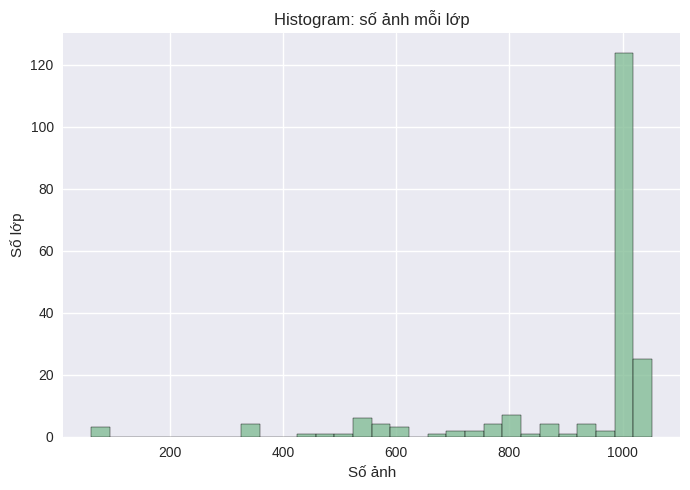

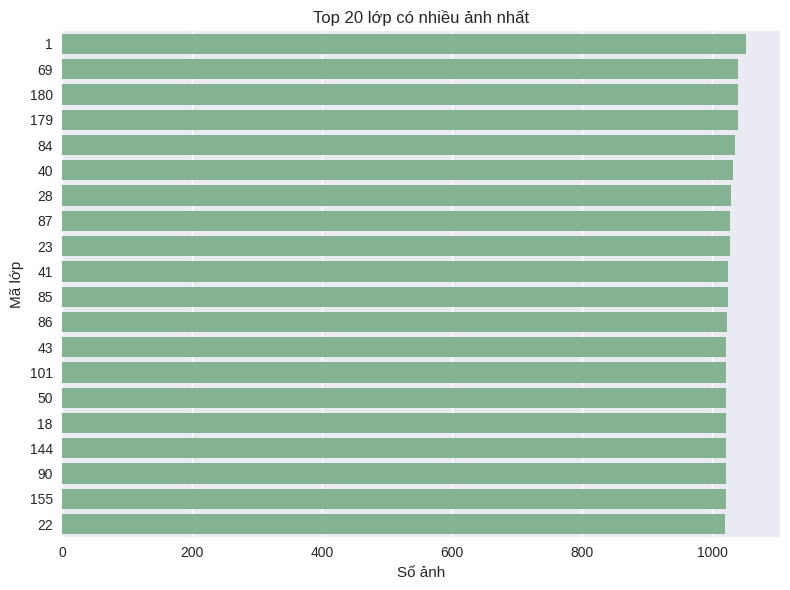

,class_id,species,count
13,110,Notopterygium incisum Ting ex H. T. Chang,61
20,117,Notopterygium forbesii Boissieu,61
81,173,Anemarrhena asphodeloides Bunge,90
126,30,Asiasarum heterotropoides (F. Schmidt) F. Maek...,346
155,57,Atractylodes ovata DC.,357
145,48,Atractylodes lancea De Candole,358
154,56,Atractylodes japonica Koidzumi ex Kitamura,358
157,59,Saposhnikovia divaricata Schischkin,441
2,100,Glehnia littoralis Fr. Schmidt ex Miquel,458
183,83,Glechoma hederacea Linn. subsp. grandis (A. Gr...,503


In [64]:
fig_hist, ax_hist = plt.subplots(figsize=(7, 5))
sns.histplot(counts_df['count'], bins=30, ax=ax_hist)
ax_hist.set_title('Histogram: số ảnh mỗi lớp')
ax_hist.set_xlabel('Số ảnh')
ax_hist.set_ylabel('Số lớp')
fig_hist.tight_layout()
fig_hist.savefig(artifacts_dir / 'class_count_histogram.png', dpi=300)
plt.show()

top_k = counts_df.sort_values('count', ascending=False).head(20)
fig_top, ax_top = plt.subplots(figsize=(8, 6))
sns.barplot(data=top_k, y='class_id', x='count', ax=ax_top)
ax_top.set_title('Top 20 lớp có nhiều ảnh nhất')
ax_top.set_xlabel('Số ảnh')
ax_top.set_ylabel('Mã lớp')
fig_top.tight_layout()
fig_top.savefig(artifacts_dir / 'top20_classes.png', dpi=300, bbox_inches='tight')
plt.show()

bottom_k = counts_df.sort_values('count', ascending=True).head(20)
bottom_k[['class_id', 'species', 'count']]


### Số lớp có ít hơn 500 ảnh
- Đếm số lớp thuộc nhóm đuôi dữ liệu.


In [65]:
if counts_df.empty:
    print("Không có dữ liệu class để đếm.")
else:
    threshold = 500
    num_classes = len(counts_df)
    num_below = (counts_df['count'] < threshold).sum()
    pct_below = num_below / num_classes * 100 if num_classes else 0
    print(f'{num_below}/{num_classes} lớp có ít hơn {threshold} ảnh ({pct_below:.2f}%)')
    counts_df[counts_df["count"] < threshold]


9/200 lớp có ít hơn 500 ảnh (4.50%)


### Top 20 lớp có ít ảnh nhất
- Bar chart để xem các lớp thiếu dữ liệu.


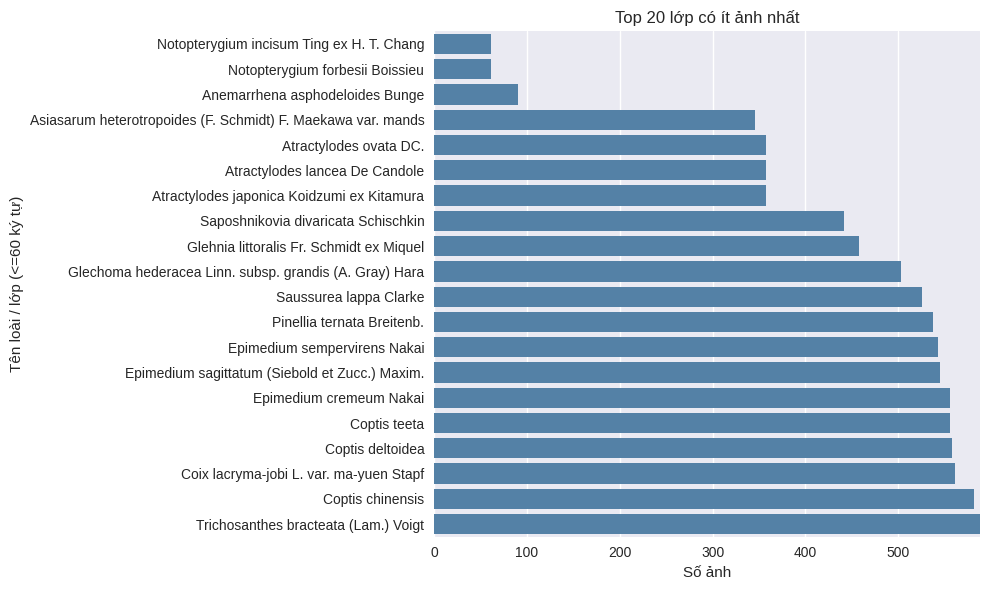

In [66]:
bottom_20 = counts_df.sort_values("count", ascending=True).head(20).copy()
bottom_20['species_display'] = bottom_20['species'].fillna(bottom_20['class_id'])
bottom_20['label'] = bottom_20['species_display'].str.slice(0, 60)

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=bottom_20, y='label', x='count', color='steelblue', ax=ax)
ax.set_title('Top 20 lớp có ít ảnh nhất')
ax.set_xlabel('Số ảnh')
ax.set_ylabel('Tên loài / lớp (<=60 ký tự)')
ax.margins(x=0)
fig.tight_layout()
fig.savefig(artifacts_dir / 'bottom_20_classes.png', dpi=300, bbox_inches='tight')
plt.show()


### Ảnh trùng giữa các lớp
- Đếm ảnh trùng tên xuất hiện ở nhiều lớp và top lớp bị ảnh hưởng.


Nhóm lớp có ảnh trùng (mỗi dòng là danh sách lớp, phân tách dấu phẩy):
1, 10, 100, 101, 102, 103, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2, 20, 200, 201, 21, 22, 23, 24, 25, 26, 27, 28, 29, 3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 4, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 5, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 6, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 7, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 8, 80, 81, 83, 84, 85, 86, 87, 88, 89, 9, 90, 91, 93, 94, 95, 96, 97, 98, 99
1, 102, 103, 14, 148, 19, 191, 35, 51, 52, 97
1, 102, 103, 14, 19, 191, 33, 35, 38, 51, 52, 97
1, 102, 103, 14, 19, 191, 35, 38, 51, 52, 97
1, 102, 103, 14, 19, 191, 35, 51, 52, 84, 97
1, 102, 103, 14, 19, 191, 35, 51, 52, 97
1, 102, 103, 147, 19, 191, 38, 97
1, 102, 103, 19, 191, 35, 51, 52, 97
1, 102, 103, 19, 191, 35, 94, 97
1, 102, 103, 19, 191, 35, 97
1, 102, 103, 19, 191, 38, 97
1, 102, 103, 19, 191, 94, 97
1, 102, 103, 19, 191, 97
10, 11, 112, 114, 115, 139, 141, 142, 84, 9
10, 11, 139, 141, 142, 84, 9
10, 11

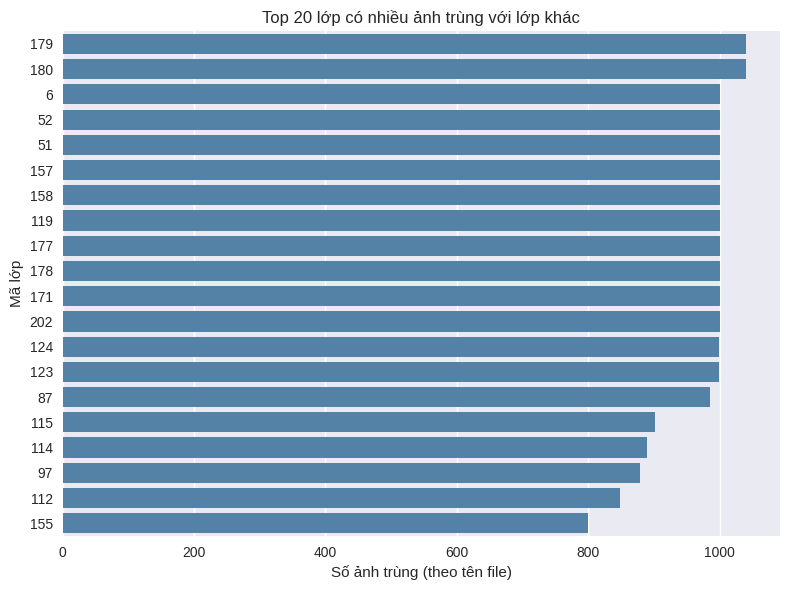

Tổng số file trùng tên giữa các lớp: 26871


In [67]:
if counts_df.empty:
    print("Không có dữ liệu class để kiểm tra trùng ảnh.")
else:
    from collections import defaultdict, Counter
    file_to_classes = defaultdict(set)
    for cls_dir in images_root.iterdir():
        if cls_dir.is_dir():
            for p in cls_dir.iterdir():
                if p.is_file():
                    file_to_classes[p.name].add(cls_dir.name)

    dup_files = {name: classes for name, classes in file_to_classes.items() if len(classes) > 1}
    group_strings = sorted({', '.join(sorted(classes)) for classes in dup_files.values()})
    if group_strings:
        print('Nhóm lớp có ảnh trùng (mỗi dòng là danh sách lớp, phân tách dấu phẩy):')
        for group in group_strings:
            print(group)
    total_dup_files = len(dup_files)
    if total_dup_files == 0:
        print("Không tìm thấy ảnh trùng tên giữa các lớp.")
    else:
        class_dup_counts = Counter()
        for classes in dup_files.values():
            for cls in classes:
                class_dup_counts[cls] += 1

        dup_df = (pd.Series(class_dup_counts, name='dup_count')
                  .sort_values(ascending=False)
                  .reset_index()
                  .rename(columns={'index': 'class_id'}))
        top_n = min(20, len(dup_df))
        top = dup_df.head(top_n)

        fig, ax = plt.subplots(figsize=(8, 6))
        sns.barplot(data=top, y='class_id', x='dup_count', color='steelblue', ax=ax)
        ax.set_title(f'Top {top_n} lớp có nhiều ảnh trùng với lớp khác')
        ax.set_xlabel('Số ảnh trùng (theo tên file)')
        ax.set_ylabel('Mã lớp')
        fig.tight_layout()
        fig.savefig(artifacts_dir / 'duplicates_per_class.png', dpi=300, bbox_inches='tight')
        plt.show()

        print(f'Tổng số file trùng tên giữa các lớp: {total_dup_files}')


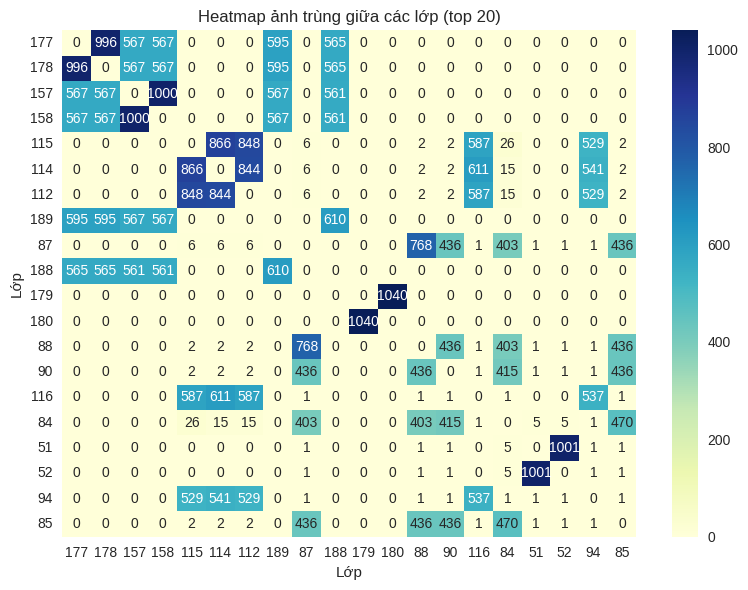

In [68]:
if counts_df.empty:
    print('Không có dữ liệu class để vẽ heatmap trùng ảnh.')
else:
    from collections import defaultdict, Counter
    from itertools import combinations

    file_to_classes = defaultdict(set)
    for cls_dir in images_root.iterdir():
        if cls_dir.is_dir():
            for p in cls_dir.iterdir():
                if p.is_file():
                    file_to_classes[p.name].add(cls_dir.name)

    pair_counts = Counter()
    for classes in file_to_classes.values():
        if len(classes) > 1:
            for a, b in combinations(sorted(classes), 2):
                pair_counts[(a, b)] += 1

    if not pair_counts:
        print('Không có ảnh trùng giữa các lớp.')
    else:
        class_totals = Counter()
        for (a, b), c in pair_counts.items():
            class_totals[a] += c
            class_totals[b] += c
        top_classes = [cls for cls, _ in class_totals.most_common(20)]
        matrix = pd.DataFrame(0, index=top_classes, columns=top_classes, dtype=int)
        for (a, b), c in pair_counts.items():
            if a in matrix.index and b in matrix.columns:
                matrix.loc[a, b] = c
                matrix.loc[b, a] = c
        plt.figure(figsize=(8, 6))
        sns.heatmap(matrix, annot=True, fmt='d', cmap='YlGnBu')
        plt.title('Heatmap ảnh trùng giữa các lớp (top 20)')
        plt.xlabel('Lớp')
        plt.ylabel('Lớp')
        plt.tight_layout()
        plt.savefig(artifacts_dir / 'duplicates_heatmap.png', dpi=300, bbox_inches='tight')
        plt.show()


### Heatmap ảnh trùng giữa các lớp
- Ma trận số lượng file trùng tên giữa các cặp lớp (top lớp bị ảnh hưởng).


### Bar chart số ảnh theo lớp (sắp xếp giảm dần)
- Trục X: tên loài (hoặc class ID nếu thiếu tên). Trục Y: số ảnh.
- Sắp xếp giảm dần để dễ so sánh class imbalance.


/tmp/ipykernel_33971/3272155686.py:13: UserWarning: Glyph 65324 (\N{FULLWIDTH LATIN CAPITAL LETTER L}) missing from font(s) Liberation Sans.
  fig.tight_layout()
/tmp/ipykernel_33971/3272155686.py:13: UserWarning: Glyph 65294 (\N{FULLWIDTH FULL STOP}) missing from font(s) Liberation Sans.
  fig.tight_layout()
/tmp/ipykernel_33971/3272155686.py:13: UserWarning: Glyph 65292 (\N{FULLWIDTH COMMA}) missing from font(s) Liberation Sans.
  fig.tight_layout()
/tmp/ipykernel_33971/3272155686.py:14: UserWarning: Glyph 65324 (\N{FULLWIDTH LATIN CAPITAL LETTER L}) missing from font(s) Liberation Sans.
  fig.savefig(artifacts_dir / 'counts_per_class.png', dpi=300, bbox_inches='tight')
/tmp/ipykernel_33971/3272155686.py:14: UserWarning: Glyph 65294 (\N{FULLWIDTH FULL STOP}) missing from font(s) Liberation Sans.
  fig.savefig(artifacts_dir / 'counts_per_class.png', dpi=300, bbox_inches='tight')
/tmp/ipykernel_33971/3272155686.py:14: UserWarning: Glyph 65292 (\N{FULLWIDTH COMMA}) missing from font(s) 

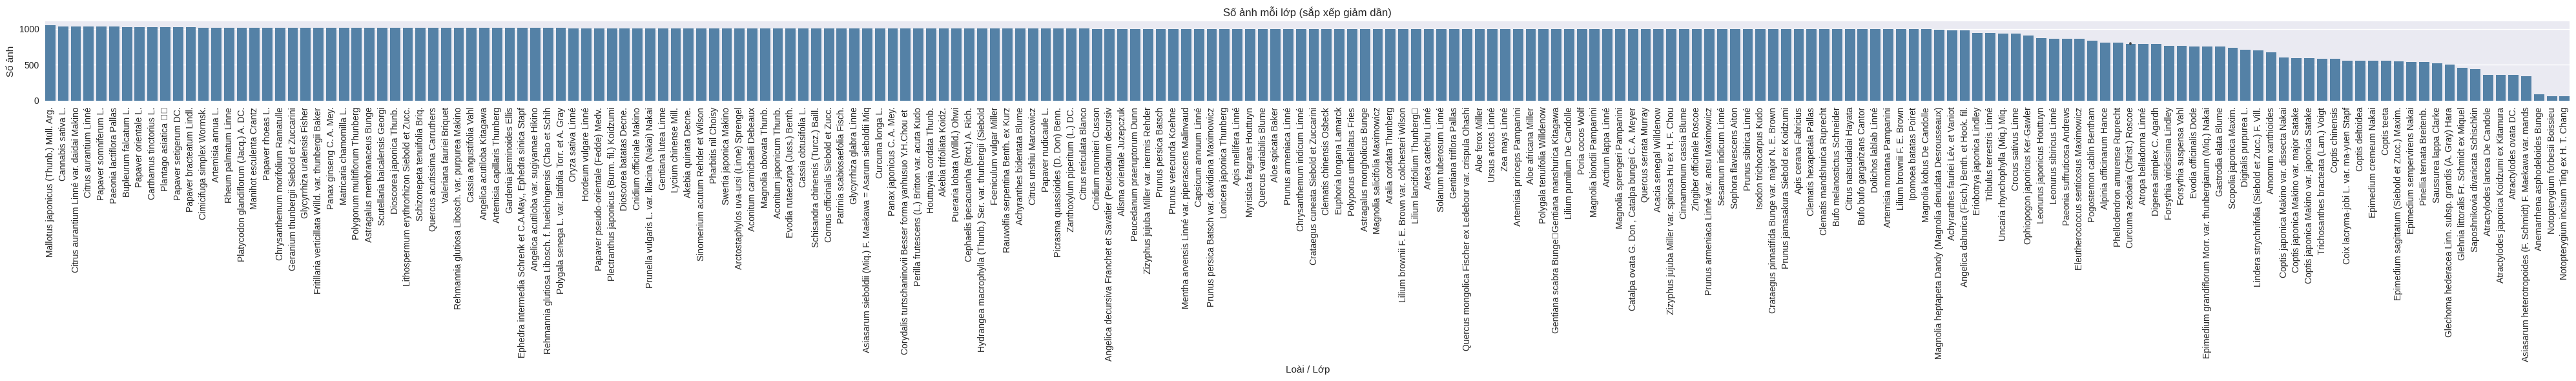

In [69]:
sorted_counts = counts_df.copy()
sorted_counts['species_display'] = sorted_counts['species'].fillna(sorted_counts['class_id'])
sorted_counts['label'] = sorted_counts['species_display'].str.slice(0, 60)
sorted_counts = sorted_counts.sort_values('count', ascending=False)

fig, ax = plt.subplots(figsize=(max(12, len(sorted_counts) * 0.2), 6))
sns.barplot(data=sorted_counts, x='label', y='count', color='steelblue', ax=ax)
plt.title('Số ảnh mỗi lớp (sắp xếp giảm dần)')
plt.xlabel('Loài / Lớp')
plt.ylabel('Số ảnh')
plt.xticks(rotation=90)
ax.margins(x=0)
fig.tight_layout()
fig.savefig(artifacts_dir / 'counts_per_class.png', dpi=300, bbox_inches='tight')
plt.show()


## Kích thước ảnh
- Thống kê phân bố kích thước và số ảnh nhỏ hơn ngưỡng (mặc định 224x224).


,width,height,min_side
count,183808.000000,183808.000000,183808.000000
mean,422.019830,441.115653,362.515364
std,79.069649,78.601104,48.385882
min,75.000000,75.000000,75.000000
10%,333.000000,333.000000,282.000000
25%,375.000000,375.000000,334.000000
50%,375.000000,500.000000,375.000000
75%,500.000000,500.000000,375.000000
90%,500.000000,500.000000,375.000000
max,3008.000000,2104.000000,2104.000000


863/183808 ảnh có chiều < 224px (0.47%)


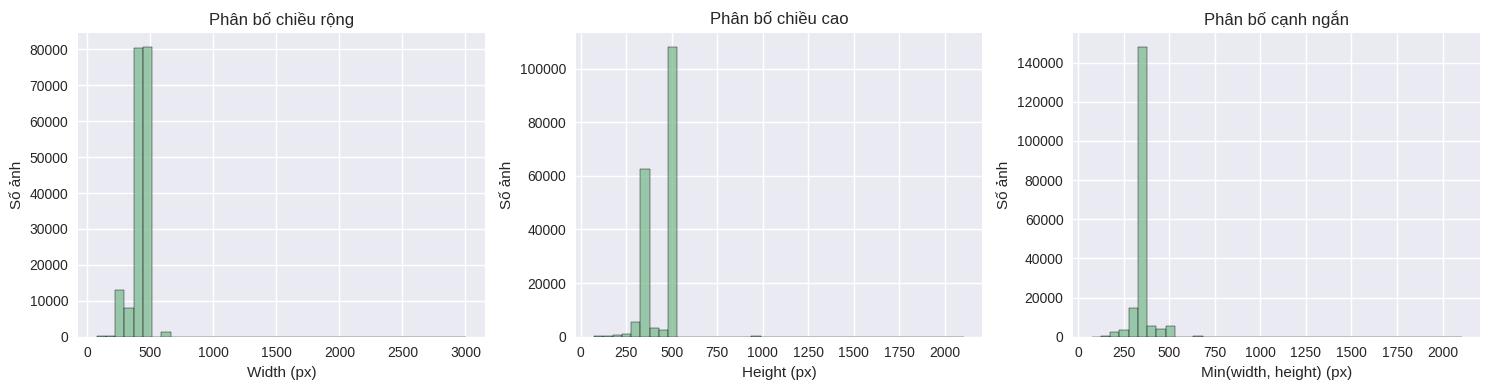

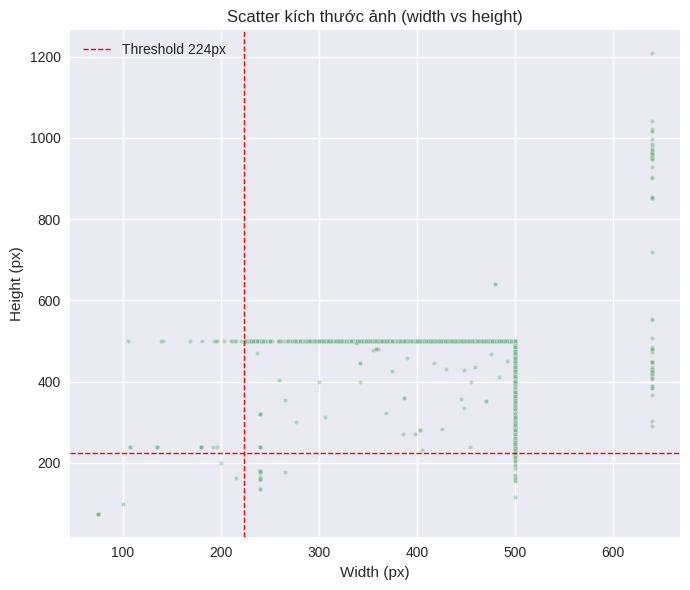

In [70]:
threshold = 224
size_records = []
read_errors = 0

for cls_dir in images_root.iterdir():
    if cls_dir.is_dir():
        for p in cls_dir.iterdir():
            if p.is_file():
                try:
                    with Image.open(p) as img:
                        w, h = img.size
                except Exception:
                    read_errors += 1
                    continue
                size_records.append({'class_id': cls_dir.name, 'width': w, 'height': h})

size_df = pd.DataFrame(size_records)

if size_df.empty:
    print('Không có dữ liệu kích thước ảnh.')
else:
    size_df['min_side'] = size_df[['width', 'height']].min(axis=1)
    summary = size_df[['width', 'height', 'min_side']].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])
    display(summary)

    small = size_df[(size_df['width'] < threshold) | (size_df['height'] < threshold)]
    num_small = len(small)
    pct_small = num_small / len(size_df) * 100 if len(size_df) else 0
    print(f"{num_small}/{len(size_df)} ảnh có chiều < {threshold}px ({pct_small:.2f}%)")
    if read_errors:
        print(f'Lỗi khi đọc ảnh: {read_errors}')

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    sns.histplot(size_df['width'], bins=40, ax=axes[0])
    axes[0].set_title('Phân bố chiều rộng')
    axes[0].set_xlabel('Width (px)')
    axes[0].set_ylabel('Số ảnh')

    sns.histplot(size_df['height'], bins=40, ax=axes[1])
    axes[1].set_title('Phân bố chiều cao')
    axes[1].set_xlabel('Height (px)')
    axes[1].set_ylabel('Số ảnh')

    sns.histplot(size_df['min_side'], bins=40, ax=axes[2])
    axes[2].set_title('Phân bố cạnh ngắn')
    axes[2].set_xlabel('Min(width, height) (px)')
    axes[2].set_ylabel('Số ảnh')

    plt.tight_layout()
    plt.show()

    sample_df = size_df.sample(min(len(size_df), 20000), random_state=0)
    plt.figure(figsize=(7, 6))
    sns.scatterplot(data=sample_df, x='width', y='height', s=10, alpha=0.5)
    plt.axvline(threshold, color='red', linestyle='--', linewidth=1, label=f'Threshold {threshold}px')
    plt.axhline(threshold, color='red', linestyle='--', linewidth=1)
    plt.title('Scatter kích thước ảnh (width vs height)')
    plt.xlabel('Width (px)')
    plt.ylabel('Height (px)')
    plt.legend()
    plt.tight_layout()
    plt.savefig(artifacts_dir / 'scatter_size_raw.png', dpi=300, bbox_inches='tight')
    plt.show()


## Grid ảnh ngẫu nhiên
- Lấy mẫu nhiều lớp, hiển thị grid để xem dữ liệu raw.


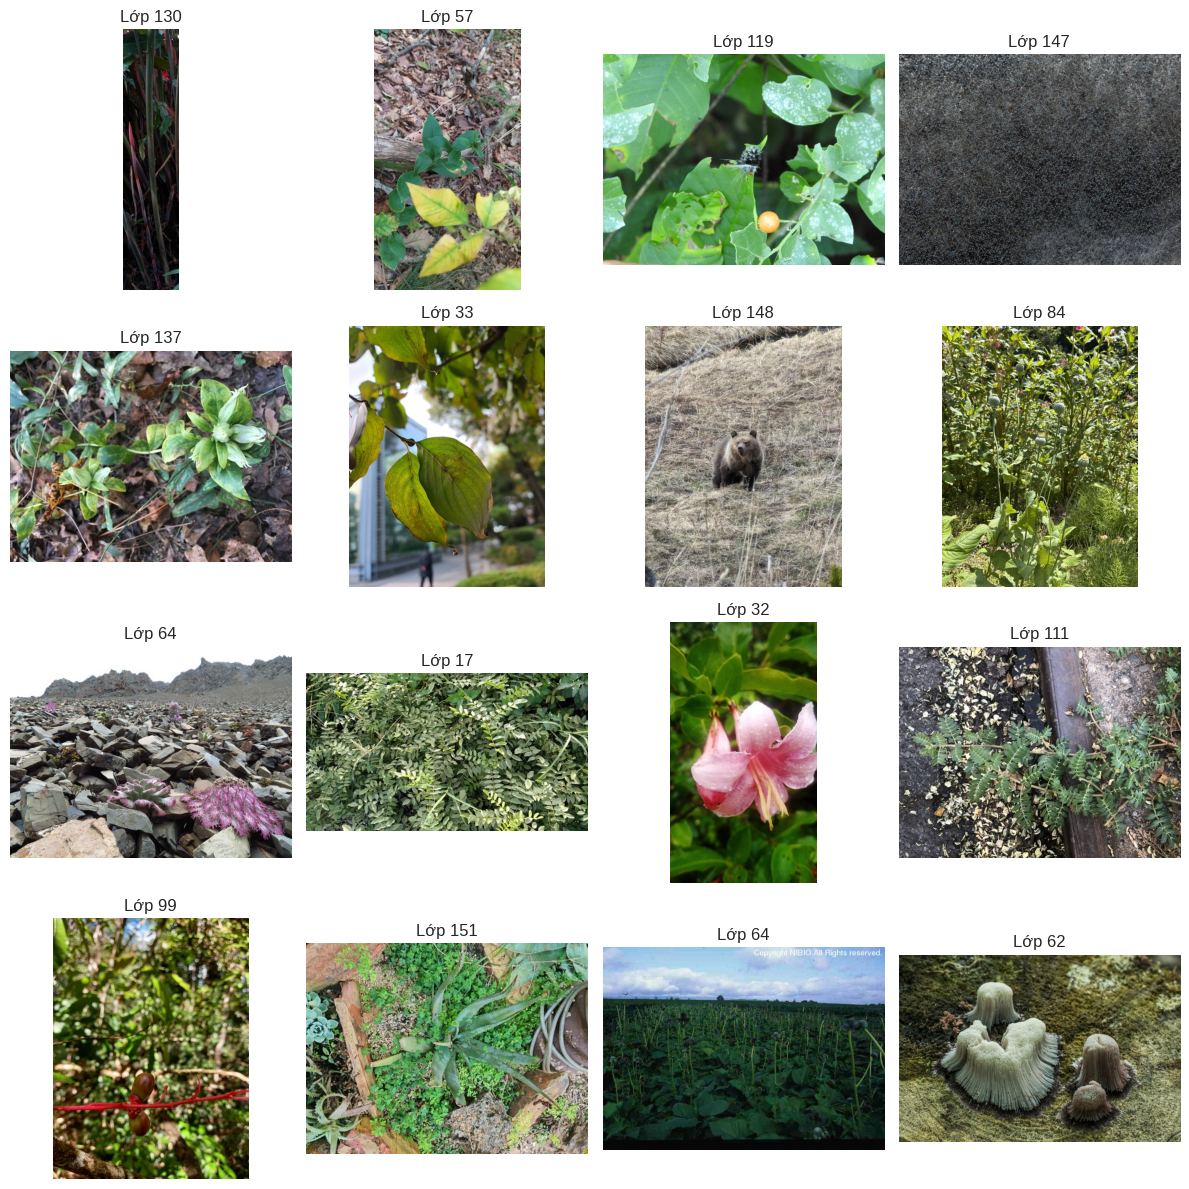

In [71]:
def sample_image_paths(image_root: Path, n_samples: int = 16):
    all_paths = []
    for cls_dir in image_root.iterdir():
        if cls_dir.is_dir():
            all_paths.extend([p for p in cls_dir.iterdir() if p.is_file()])
    random.shuffle(all_paths)
    return all_paths[:n_samples]

sample_paths = sample_image_paths(images_root, n_samples=16)
if not sample_paths:
    print('Không tìm thấy ảnh để hiển thị (sample_paths rỗng).')
else:
    n_cols = 4
    n_rows = max(1, int(np.ceil(len(sample_paths) / n_cols)))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3 * n_rows))
    axes = axes.flatten()

    for ax, img_path in zip(axes, sample_paths):
        try:
            img = Image.open(img_path).convert('RGB')
            ax.imshow(img)
            cls_id = img_path.parent.name
            ax.set_title(f'Lớp {cls_id}')
            ax.axis('off')
        except Exception as exc:
            ax.axis('off')
            ax.set_title(f'Lỗi: {exc}')

    for ax in axes[len(sample_paths):]:
        ax.axis('off')
    plt.tight_layout()
    plt.show()
